In [1]:
import os
from astropy.table import Table
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

In [2]:
import desisim
import desisurvey
import desimodel.io
import desimodel.footprint

# Environment Variables 

Set some environment variables and create output directories

`$DESISURVEY` = `${SCRATCH}`/quicksurvey_example/survey/

In [3]:
basedir = os.path.join(os.getenv('SCRATCH'),'quicksurvey_example')
surveydir = os.environ['DESISURVEY'] = os.path.join(basedir,'survey')
print(os.environ['DESISURVEY'])

/global/cscratch1/sd/forero/quicksurvey_example/survey


In [4]:
targetdir = os.path.join(basedir,'targets')
nospectradir = os.path.join(targetdir,'no_spectra')
fullspectradir = os.path.join(targetdir,'full_spectra')
zcatbrightdir = os.path.join(basedir,'zcat/bright')
zcatdarkdir = os.path.join(basedir,'zcat/dark')
os.makedirs(targetdir, exist_ok=True)
os.makedirs(zcatbrightdir, exist_ok=True)
os.makedirs(zcatdarkdir, exist_ok=True)
os.makedirs(nospectradir, exist_ok=True)
os.makedirs(fullspectradir, exist_ok=True)

# Run select_mock_targets

In [22]:
configfile = os.path.join(targetdir,'select-mock-targets.yaml')
os.environ['MPICH_GNI_FORK_MODE'] = 'FULLCOPY'
os.environ['KMP_AFFINITY'] = 'disabled'
os.environ['OMP_NUM_THREADS'] = '1'
cmd = "srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets -O {targetdir} --config {configfile}"
cmd += " --seed 1 --nproc 16 --nside 16 --tiles {tilefile}"
cmd = cmd.format(targetdir=targetdir, tilefile=tilefile, configfile=configfile)
print(cmd)

srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00 mpi_select_mock_targets -O /global/cscratch1/sd/forero/quicksurvey_example/targets --config /global/cscratch1/sd/forero/quicksurvey_example/targets/select-mock-targets.yaml --seed 1 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/forero/quicksurvey_example/targets/test-tiles.fits


In [20]:
!$cmd

In [23]:
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
!$cmd

join_mock_targets --mockdir /global/cscratch1/sd/forero/quicksurvey_example/targets --force
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/sky.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/standards-dark.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/standards-bright.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/targets.fits
INFO:build.py:932:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/truth.fits
INFO:build.py:1004:join_targets_truth: Generating merged target list /global/cscratch1/sd/forero/quicksurvey_example/targets/mtl.fits
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.08392715454101562
DEBUG: calc_priority has 277778 unobserved targets
0 of 277778 targets have 

In [24]:
# some sanity checks on the results

In [73]:
targetdir = 'targets/no_spectra/'
targets = fitsio.read(targetdir+'/targets.fits')
truth   = fitsio.read(targetdir+'/truth.fits')
mtl     = fitsio.read(targetdir+'/mtl.fits')
std     = fitsio.read(targetdir+'/standards-dark.fits')
sky     = fitsio.read(targetdir+'/sky.fits')

In [74]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


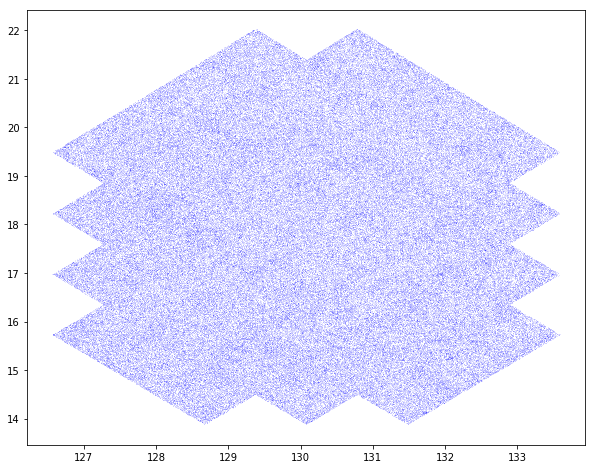

In [83]:
plt.figure(figsize=(10,8))
plt.plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)

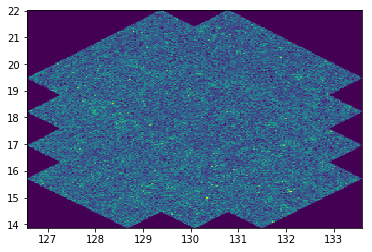

In [89]:
a = plt.hist2d(mtl['RA'], mtl['DEC'], bins=200)

In [77]:
targetdir = 'targets/full_spectra/'
targets = fitsio.read(targetdir+'/targets.fits')
truth   = fitsio.read(targetdir+'/truth.fits')
mtl     = fitsio.read(targetdir+'/mtl.fits')
std     = fitsio.read(targetdir+'/standards-dark.fits')
sky     = fitsio.read(targetdir+'/sky.fits')

In [78]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))

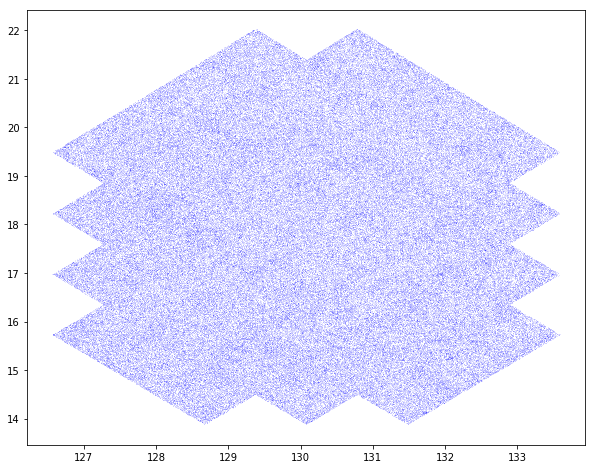

In [88]:
plt.figure(figsize=(10,8))
plt.plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
#plt.plot(std['RA'], std['DEC'], 'm.')

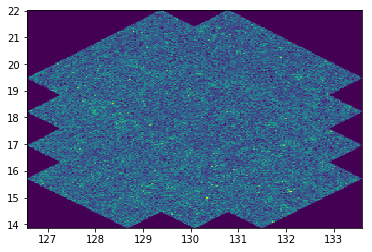

In [86]:
a = plt.hist2d(mtl['RA'], mtl['DEC'], bins=200)

# Run quicksurvey

Requires this [PR](https://github.com/desihub/desisim/pull/249) (branch `surveysim_epochs`)

In [28]:
quicksurvey_cmd = "quicksurvey -T targets/ -E {exposures}  --output_dir {outputdir} -f $(which fiberassign)"
quicksurvey_cmd += " -t {fiberassign_template} -D {fiberassign_dates}"

cmd = quicksurvey_cmd.format(exposures='survey/exposures_bright.fits', 
                             outputdir=zcatbrightdir, 
                             fiberassign_template='fiberassign/template_fiberassign_bright.txt', 
                            fiberassign_dates='fiberassign/fiberassign_dates_bright.txt')
print(cmd)

!$cmd

quicksurvey -T targets/ -E survey/exposures_bright.fits  --output_dir /global/cscratch1/sd/forero/quicksurvey_example/zcat/bright -f $(which fiberassign) -t fiberassign/template_fiberassign_bright.txt -D fiberassign/fiberassign_dates_bright.txt
['2019-12-06', '2020-02-01', '2020-08-01', '9999-99-99']
tiles in epoch 0 [2019-12-06 to 2020-02-01]: 2
tiles in epoch 1 [2020-02-01 to 2020-08-01]: 1
tiles in epoch 2 [2020-08-01 to 9999-99-99]: 1
['TARGETID', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'MAG', 'DECAM_FLUX', 'WISE_FLUX', 'OIIFLUX', 'HBETAFLUX', 'TEFF', 'LOGG', 'FEH']
--- Epoch 0 ---
Wed Aug  2 04:10:38 2017 Starting MTL
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.0842435359954834
DEBUG: calc_priority has 277778 unobserved targets
0 of 277778 targets have priority zero, setting N_obs=0.
Wed Aug  2 04:10:41 2017 Finished MTL
2 tiles to be included in fiberassign

In [29]:
cmd = quicksurvey_cmd.format(exposures='survey/exposures_dark.fits', 
                             outputdir=zcatdarkdir, 
                             fiberassign_template='fiberassign/template_fiberassign_dark.txt', 
                            fiberassign_dates='fiberassign/fiberassign_dates_dark.txt')
print(cmd)

!$cmd

quicksurvey -T targets/ -E survey/exposures_dark.fits  --output_dir /global/cscratch1/sd/forero/quicksurvey_example/zcat/dark -f $(which fiberassign) -t fiberassign/template_fiberassign_dark.txt -D fiberassign/fiberassign_dates_dark.txt
['2019-10-25', '2020-02-01', '2020-12-01', '9999-99-99']
tiles in epoch 0 [2019-10-25 to 2020-02-01]: 3
tiles in epoch 1 [2020-02-01 to 2020-12-01]: 1
tiles in epoch 2 [2020-12-01 to 9999-99-99]: 2
['TARGETID', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'MAG', 'DECAM_FLUX', 'WISE_FLUX', 'OIIFLUX', 'HBETAFLUX', 'TEFF', 'LOGG', 'FEH']
--- Epoch 0 ---
Wed Aug  2 04:11:19 2017 Starting MTL
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.08867955207824707
DEBUG: calc_priority has 277778 unobserved targets
0 of 277778 targets have priority zero, setting N_obs=0.
Wed Aug  2 04:11:22 2017 Finished MTL
3 tiles to be included in fiberassign
Wed Au

In [41]:
#some simple plots
zcatfilename = os.path.join(zcatbrightdir, '2', 'zcat.fits')
zcat_bright = Table.read(zcatfilename)

zcatfilename = os.path.join(zcatdarkdir, '2', 'zcat.fits')
zcat_dark = Table.read(zcatfilename)

In [42]:
zcat_bright

TARGETID,BRICKNAME,SPECTYPE,Z,ZERR,ZWARN,NUMOBS
int64,str8,str10,float32,float32,int32,int32
197670393310965406,,GALAXY,0.0397378,4.5085e-05,0,1
3781812605824287902,,GALAXY,0.332176,5.77663e-05,0,1
394272357687440947,,GALAXY,0.0599294,4.59616e-05,0,1
4266256146595931435,,GALAXY,0.0395882,4.50796e-05,0,1
4284614472941967603,,GALAXY,0.175291,5.09626e-05,0,1
3345610071236726873,,GALAXY,0.160084,5.03074e-05,0,1
2016648862077323548,,STAR,8.60327e-05,6.00433e-05,0,1
3841736711635995033,,GALAXY,0.238449,5.37038e-05,0,1
1072813565588357315,,GALAXY,0.447996,6.27921e-05,0,1


In [43]:
zcat_dark

TARGETID,BRICKNAME,SPECTYPE,Z,ZERR,ZWARN,NUMOBS
int64,str8,str10,float32,float32,int32,int32
1428163099438539392,,GALAXY,0.95416,8.92791e-05,0,1
1165470267233427202,,GALAXY,0.777187,0.000222725,0,1
1425785097067217525,,GALAXY,1.18138,0.000204761,4,1
3611084534936713678,,GALAXY,1.27821,0.000211468,0,1
406432196981470226,,GALAXY,0.752931,0.000246662,4,1
1473347127496465914,,GALAXY,0.815055,0.000129988,0,1
3771381741375554146,,GALAXY,0.933255,0.000100442,0,1
1137498911039961740,,GALAXY,0.959731,0.000230419,0,1
1739035040556445487,,GALAXY,0.959795,0.000128031,0,1


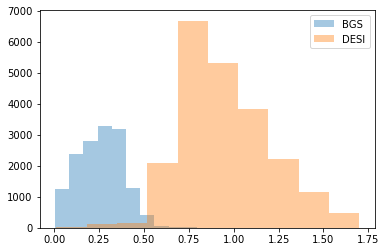

In [44]:
a = plt.hist(zcat_bright['Z'][zcat_bright['SPECTYPE']=='GALAXY'], alpha=0.4, label='BGS')
a = plt.hist(zcat_dark['Z'][zcat_dark['SPECTYPE']=='GALAXY'], label='DESI', alpha=0.4)
plt.legend()

In [49]:
cmd = "srun -N 2 -n 4 -c 16 -p debug -C haswell -t 00:30:00 mpi_select_mock_targets -O targets "
cmd += " --config targets/select-mock-targets.yaml --seed 1 --nproc 4 --nside 16 --tiles targets/test-tiles.fits"
cmd += " --no-spectra"
print(cmd)

srun -N 2 -n 4 -c 16 -p debug -C haswell -t 00:30:00 mpi_select_mock_targets -O targets  --config targets/select-mock-targets.yaml --seed 1 --nproc 4 --nside 16 --tiles targets/test-tiles.fits --no-spectra


In [50]:
! $cmd

srun: job 6160803 queued and waiting for resources
srun: job 6160803 has been allocated resources
INFO:mpi_select_mock_targets:49:<module>: This run is NOT  going to generate mock spectra
INFO:mpi_select_mock_targets:49:<module>: This run is NOT  going to generate mock spectra
INFO:mpi_select_mock_targets:49:<module>: This run is NOT  going to generate mock spectra
INFO:mpi_select_mock_targets:49:<module>: This run is NOT  going to generate mock spectra
INFO:mpi_select_mock_targets:86:<module>: 10 tiles
INFO:mpi_select_mock_targets:97:<module>: 7/7 pixels remaining to do
INFO:mpi_select_mock_targets:138:<module>: rank 0 processes 1 pixels [270]
INFO:mpi_select_mock_targets:138:<module>: rank 2 processes 2 pixels [292 293]
INFO:mpi_select_mock_targets:138:<module>: rank 1 processes 2 pixels [271 289]
INFO:mpi_select_mock_targets:138:<module>: rank 3 processes 2 pixels [294 295]
INFO:build.py:535:targets_truth_no_spectra: We are NOT creating spectra for Targets+Truth!
INFO:build.py:551:t